In [1]:
from paretoCardinalityInfluence import *
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

# Import influence datasets
data_path_HEPT = '../../datasets/raw_data/influence/NetHEPT/hep.txt'
data_path_PHY = '../../datasets/raw_data/influence/NetPHY/phy.txt'

G_HEPT = import_influence_data(data_path_HEPT)
G_PHY = import_influence_data(data_path_PHY)

2026-01-26 16:35:54,926 |INFO: Imported influence graph with 1673 nodes and 3863 edges
2026-01-26 16:35:56,607 |INFO: Imported influence graph with 912 nodes and 8748 edges


In [2]:
def findApproximateParetoSolutionsInfluence(G, k_max, num_samples=35, num_runs=10, dataset_name=""):
    '''
    Run algorithms over multiple runs, aggregate results, and plot mean +/- std.
    Parameters:
    - G: Graph
    - k_max: Maximum seed set size (cardinality)
    - num_samples: Number of Monte Carlo samples (per run)
    - num_runs: Number of independent runs
    - dataset_name: Name of the dataset for plotting
    '''
    algo_names = ["ParetoGreedy", "TopK", "Random"]
    # containers across runs
    all_influences = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}

    for run in range(num_runs):
        
        # Generate graph samples once to share across algorithms (per run)
        graph_samples = []
        for i in range(num_samples):
            G_sample = nx.Graph()
            neighbors = defaultdict(set)
            connected_components = defaultdict()
            for u, v, data in G.edges(data=True):
                success = np.random.uniform(0, 1)
                if success < data['weight']:
                    G_sample.add_edge(u, v)
                    neighbors[u].add(v)
                    neighbors[v].add(u)
            for c in nx.connected_components(G_sample):
                for node in c:
                    connected_components[node] = c
            graph_samples.append((G_sample, neighbors, connected_components))
        
        # Greedy Cardinality
        paretoCard = paretoCardinalityInfluence(G=G, k_max=k_max, num_samples=num_samples, graph_samples=graph_samples)
        _, _, runTime = paretoCard.greedyCardinality()
        infl = []
        current_influence = 0
        
        for k in range(1, k_max + 1):
            if k in paretoCard.kSolDict:
                current_influence = paretoCard.kSolDict[k]['Influence']
            infl.append(current_influence)
        
        all_influences['ParetoGreedy'].append(np.array(infl, dtype=float))
        all_runtimes['ParetoGreedy'].append(runTime)
       
        # Top K
        paretoCard2 = paretoCardinalityInfluence(G=G, k_max=k_max, num_samples=num_samples, graph_samples=graph_samples)
        _, _, runTime = paretoCard2.top_k()
        infl = [paretoCard2.kSolDict.get(k, {'Influence': 0})['Influence'] for k in range(1, k_max + 1)]
        all_influences['TopK'].append(np.array(infl, dtype=float))
        all_runtimes['TopK'].append(runTime)
        
        # Random
        paretoCard3 = paretoCardinalityInfluence(G=G, k_max=k_max, num_samples=num_samples, graph_samples=graph_samples)
        _, _, runTime = paretoCard3.random_selection()
        infl = [paretoCard3.kSolDict.get(k, {'Influence': 0})['Influence'] for k in range(1, k_max + 1)]
        all_influences['Random'].append(np.array(infl, dtype=float))
        all_runtimes['Random'].append(runTime)
    
    # compute mean and std across runs for each algorithm
    mean_influences = {}
    std_influences = {}
    for alg in algo_names:
        stacked = np.vstack(all_influences[alg])  # shape (num_runs, k_max)
        mean_influences[alg] = np.mean(stacked, axis=0)
        std_influences[alg] = np.std(stacked, axis=0) * 0.5
    
    # Plot mean influence with shaded std band (consistent with knapsack formatting)
    colors = plt.get_cmap("tab10").colors
    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
    markers = ['o', 's', '^', 'v', 'D']
    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i, alg in enumerate(algo_names):
        mean = mean_influences[alg]
        std = std_influences[alg]
        is_pareto = alg in {"ParetoGreedy"}
        marker_size = 7 if is_pareto else 6
        line_style = '-' if is_pareto else ':'
        color = colors[i]
        marker = markers[i % len(markers)]
        zorder = 3
        if alg == "ParetoGreedy":
            color = colors[3]
            marker = "D"
            zorder = 4
        label = rf"\texttt{{{alg}}} (ours)" if is_pareto else rf"\texttt{{{alg}}}"
        ax.plot(range(1, k_max + 1), mean, label=label, color=color, linestyle=line_style, marker=marker, markersize=marker_size, markeredgewidth=1.1, markeredgecolor='k', linewidth=1.8, zorder=zorder)
        ax.fill_between(range(1, k_max + 1), np.clip(mean - std, 0, None), mean + std, color=color, alpha=0.18, zorder=2)
    
    ax.set_xlabel(r'Cardinality ($k$)', fontsize=24)
    ax.set_ylabel(r'Mean influence ($\bar{f}$)', fontsize=24)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=20)
    # Legend inside bottom right
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.98, 0.02), fontsize=18, frameon=True)
    
    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "cardinality"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_cardinality.pdf"
    fig.savefig(out_path, bbox_inches="tight")
    plt.show()
    
    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))
    
    return None

### NetHEPT Experiments

2026-01-26 16:35:56,778 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:1673, k=50
2026-01-26 16:35:56,819 |INFO: Cardinality Greedy Solution for k_max:50, Influence:224.000, Runtime = 0.04 seconds
2026-01-26 16:35:56,819 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:1673, k=50
2026-01-26 16:35:56,852 |INFO: Top-k Solution for k_max:50, Influence:165.600, Runtime = 0.03 seconds
2026-01-26 16:35:56,853 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:1673, k=50
2026-01-26 16:35:56,856 |INFO: Random Selection Solution for k_max:50, Influence:73.400, Runtime = 0.00 seconds
2026-01-26 16:35:56,966 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:1673, k=50
2026-01-26 16:35:57,007 |INFO: Cardinality Greedy Solution for k_max:50, Influence:201.200, Runtime = 0.04 seconds
2026-01-26 16:35:57,007 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:1673, k=50
2026-0

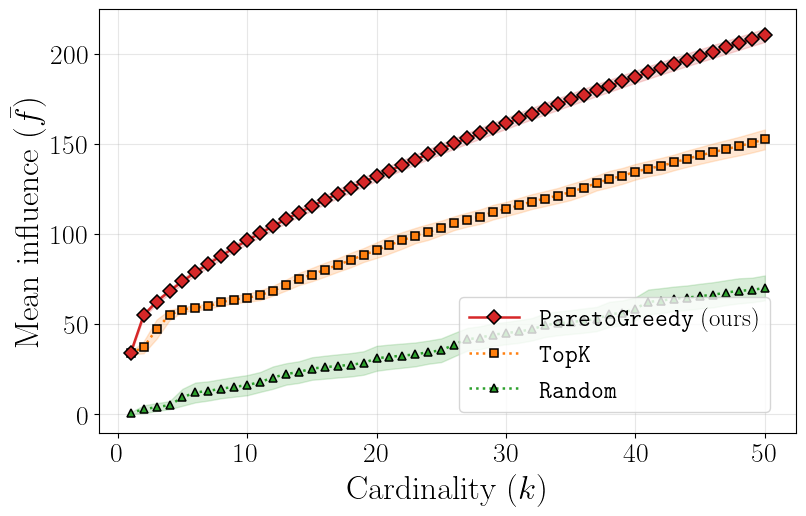

2026-01-26 16:36:01,261 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy: 0.040 ± 0.002
  - TopK: 0.033 ± 0.001
  - Random: 0.002 ± 0.000


In [3]:
# Parameters
k_max = 50
num_samples = 5
num_runs = 20

findApproximateParetoSolutionsInfluence(G_HEPT, k_max, num_samples, num_runs, "NetHEPT")

### NetPHY Experiments

2026-01-26 16:36:01,503 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:912, k=50
2026-01-26 16:36:01,557 |INFO: Cardinality Greedy Solution for k_max:50, Influence:449.800, Runtime = 0.05 seconds
2026-01-26 16:36:01,558 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:912, k=50
2026-01-26 16:36:01,607 |INFO: Top-k Solution for k_max:50, Influence:360.400, Runtime = 0.05 seconds
2026-01-26 16:36:01,607 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:912, k=50
2026-01-26 16:36:01,614 |INFO: Random Selection Solution for k_max:50, Influence:355.600, Runtime = 0.01 seconds
2026-01-26 16:36:01,845 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:912, k=50
2026-01-26 16:36:01,895 |INFO: Cardinality Greedy Solution for k_max:50, Influence:444.200, Runtime = 0.05 seconds
2026-01-26 16:36:01,896 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:912, k=50
2026-01-26

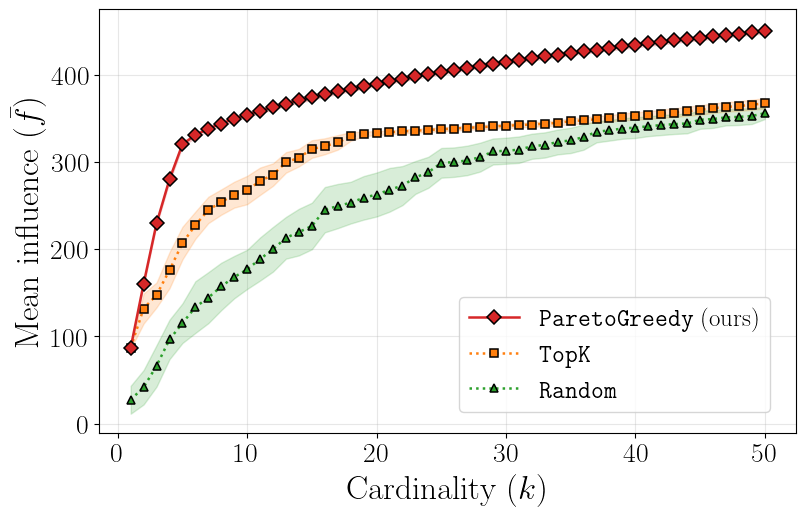

2026-01-26 16:36:08,425 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy: 0.053 ± 0.002
  - TopK: 0.045 ± 0.004
  - Random: 0.005 ± 0.001


In [4]:
# Run for NetPHY
findApproximateParetoSolutionsInfluence(G_PHY, k_max, num_samples, num_runs, "NetPHY")